<a href="https://colab.research.google.com/github/abdullah-hamid/tmlc-fellowship/blob/main/eCommerce_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from google.colab import drive


# Code downloaded from Kaggle onto my Google Drive

eCommerce data found at https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification

In [14]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import eCommerce data

Import data and encode labels to integers. Split data between training and testing sets. 

In [15]:
df = pd.read_csv('/content/drive/MyDrive/Data/ecommerceDataset.csv',header=None)
df.columns = ['category', 'description']
df_orig = copy.deepcopy(df)
le = preprocessing.LabelEncoder()
label = le.fit_transform(df['category'])
df = df.drop('category', axis=1)
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.20, random_state=42, shuffle=True)

df.head()

,description
0,Paper Plane Design Framed Wall Hanging Motivat...
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,SAF 'UV Textured Modern Art Print Framed' Pain...
3,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Incredible Gifts India Wooden Happy Birthday U...


# Preview data makeup

The descriptions are roughly the same size with an outlier that's 50,000+ words long. Seeing that the median is smaller than the standard deviation, we may have an issue with high variance. Looking at the histogram (and max length) there's more likely an issue with outliers. 

In [16]:
lens = X_train.description.str.len()
text1 = '''The mean description length is {:.0f} words, the standard deviation is 
{:.0f} words and the longest descriptions is {:.0f} words.'''.format(lens.mean(), lens.std(), lens.max())
text2 = 'The median description length is {:.0f}.'.format(lens.median())
print(text1)
print()
print(text2)

The mean description length is 718 words, the standard deviation is 
1004 words and the longest descriptions is 50403 words.

The median description length is 488.


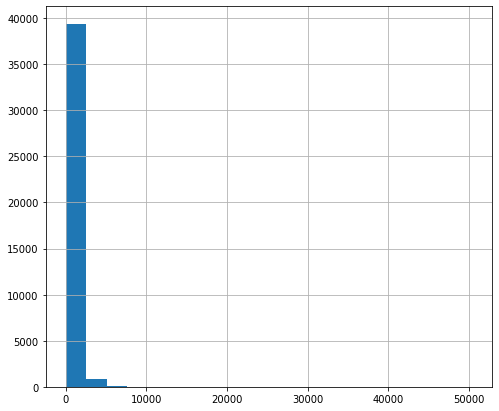

In [17]:
lens.hist(bins=20)

# Categorical Make Up of Data

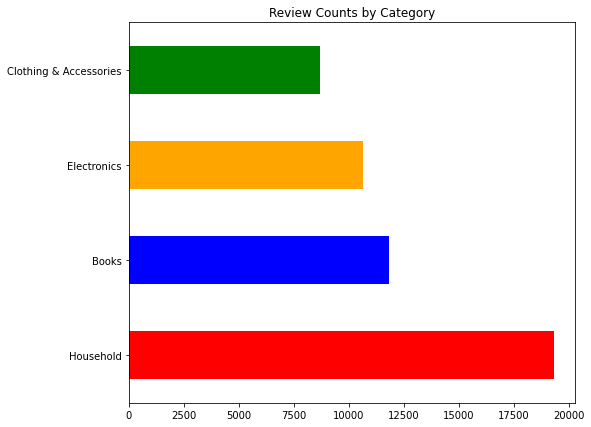

In [18]:
plt.rcParams['figure.figsize'] = [8, 7]

colors = ['red','blue','orange', 'green']
ax = df_orig['category'].value_counts().plot.barh(title='Review Counts by Category',color =  colors)


# Preprocess Data



*   Remove Punctuation
*   Use Term Frequency-Inverse Document Frequency (tf-idf) to give weight to how important a word is compared to others.
  * Uses unigrams only. Bigrams and trigrams degraded accuracy. 



In [19]:
# Remove punctuation
X_train['description'] = X_train['description'].str.replace('[^\w\s]','')
X_train.description.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


32700    ICW Girls Scarf MultiColoured Small 22 x 72 In...
47130    ULANZI DH03 L Bracket Handle Griped Mic Stand ...
20274    Penguin Essentials My Family and Other Animals...
45776    Gizga Essentials Professional Lens Pen Cleanin...
7091     House of Quirk Plastic Storage Organiser Beige...
Name: description, dtype: object

In [20]:
m = X_train.shape[0]


In [21]:
# TD-IDF Vectorizer -- consists soley of unigrams
tf_idf_vec = TfidfVectorizer(ngram_range=(1,1),strip_accents='unicode', sublinear_tf=True)

train_term_doc = tf_idf_vec.fit_transform(X_train['description'].values.astype('U'))  #Expecting unicode
test_term_doc = tf_idf_vec.transform(X_test['description'])

TF-IDF's are sparse matrices as evidenced below.

In [22]:

test_term_doc

<10085x108796 sparse matrix of type '<class 'numpy.float64'>'
	with 696320 stored elements in Compressed Sparse Row format>

## Use scikit-learn to build a Naive Bayes classifier. Over 90% accuracy outside the box.

In [23]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(train_term_doc, y_train)

MultinomialNB()

## Summary of results on test data

The classifier quantitavely performed worst on the household category. This isn't necassarily surprising as household categories is the largest subset of data as seen in the bar plot above. 

                        precision    recall  f1-score   support

                 Books       0.97      0.91      0.94      2387
Clothing & Accessories       0.98      0.89      0.93      1744
           Electronics       0.96      0.86      0.91      2067
             Household       0.86      0.98      0.92      3887

              accuracy                           0.92     10085
             macro avg       0.95      0.91      0.93     10085
          weighted avg       0.93      0.92      0.92     10085

confusion matrix:


Text(0.5, 1.0, 'Confusion Matrix')

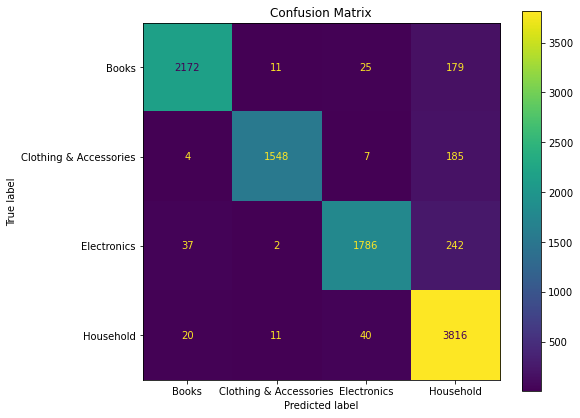

In [24]:
y_pred = naive_bayes_classifier.predict(test_term_doc)


print(metrics.classification_report(y_test, y_pred,
                                            target_names=le.classes_))

print("confusion matrix:")
cm = metrics.confusion_matrix(y_test, y_pred)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.title("Confusion Matrix")